# Gravity data processing

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
import pygmt

import ensaio
import verde as vd
import boule as bl
import harmonica as hm

## Download gravity data

In [2]:
fname = ensaio.fetch_southern_africa_gravity(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/southern-africa-gravity.csv.xz')

In [3]:
data = pd.read_csv(fname)
data

longitude  latitude  height_sea_level_m  gravity_mgal
0       18.34444 -34.12971                32.2     979656.12
1       18.36028 -34.08833               592.5     979508.21
2       18.37418 -34.19583                18.4     979666.46
3       18.40388 -34.23972                25.0     979671.03
4       18.41112 -34.16444               228.7     979616.11
...          ...       ...                 ...           ...
14354   21.22500 -17.95833              1053.1     978182.09
14355   21.27500 -17.98333              1033.3     978183.09
14356   21.70833 -17.99166              1041.8     978182.69
14357   21.85000 -17.95833              1033.3     978193.18
14358   21.98333 -17.94166              1022.6     978211.38

[14359 rows x 4 columns]

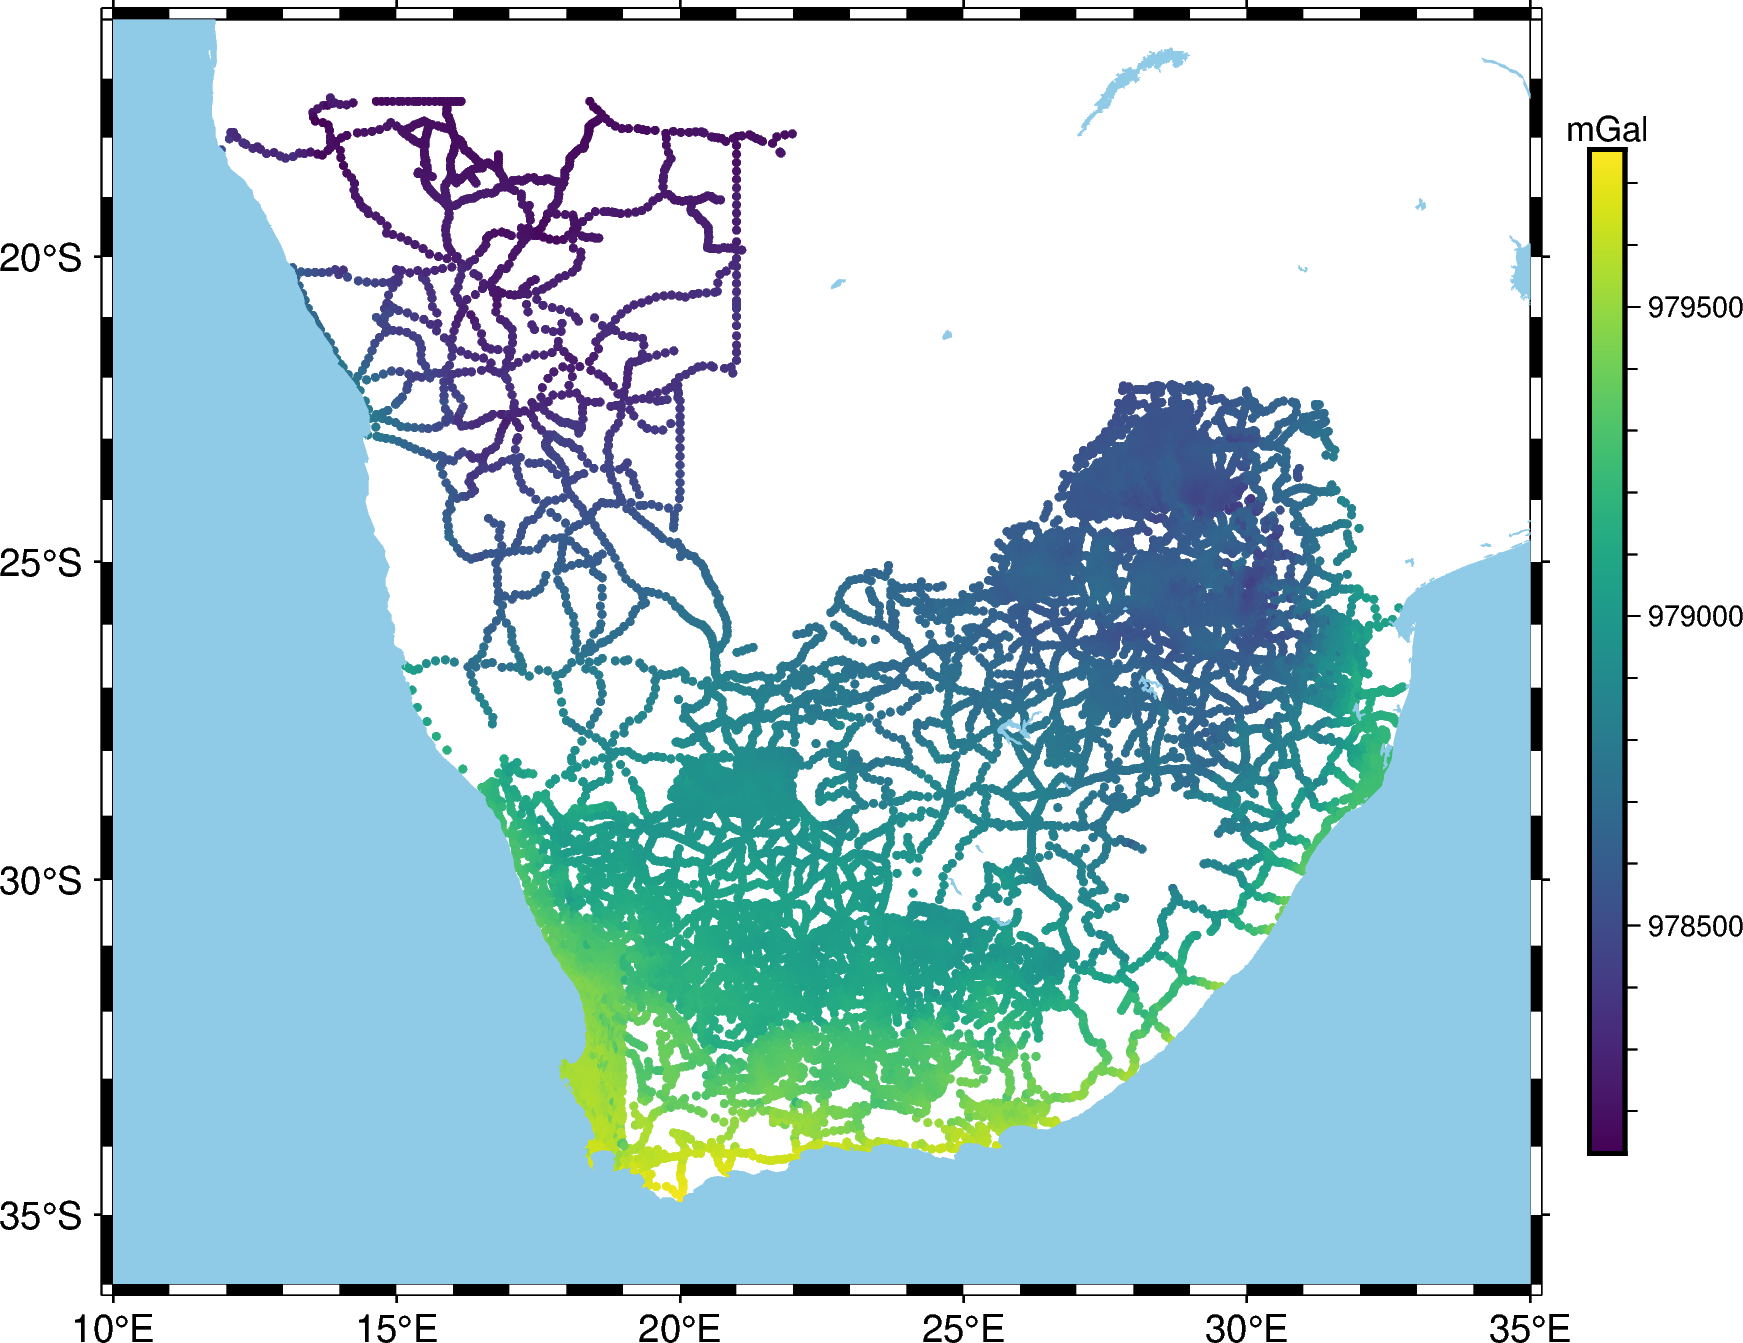

In [4]:
gmt_projection = "M12c"

fig = pygmt.Figure()
vmin, vmax = data.gravity_mgal.min(), data.gravity_mgal.max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_mgal,
    cmap=True,
    style="c2p",
    projection=gmt_projection,
    frame="af",
)
fig.coast(water="#8fcae7")
fig.colorbar(position="JMR+o0.5c/0c+w8.5c/0.3c", frame=["af", 'y+l"mGal"'])
fig.show()

## Download geoid to convert heights to ellipsoidal heights

In [5]:
fname = ensaio.fetch_earth_geoid(version=1)

In [6]:
geoid = xr.load_dataarray(fname)
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)> Size: 19MB
array([[-29.5, -29.5, -29.5, ..., -29.5, -29.5, -29.5],
       [-29.5, -29.5, -29.5, ..., -29.5, -29.5, -29.5],
       [-29.6, -29.6, -29.6, ..., -29.6, -29.6, -29.6],
       ...,
       [ 14.7,  14.7,  14.7, ...,  14.7,  14.7,  14.7],
       [ 15.2,  15.2,  15.2, ...,  15.2,  15.2,  15.2],
       [ 15.4,  15.4,  15.4, ...,  15.4,  15.4,  15.4]])
Coordinates:
  * longitude  (longitude) float64 17kB -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude   (latitude) float64 9kB -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

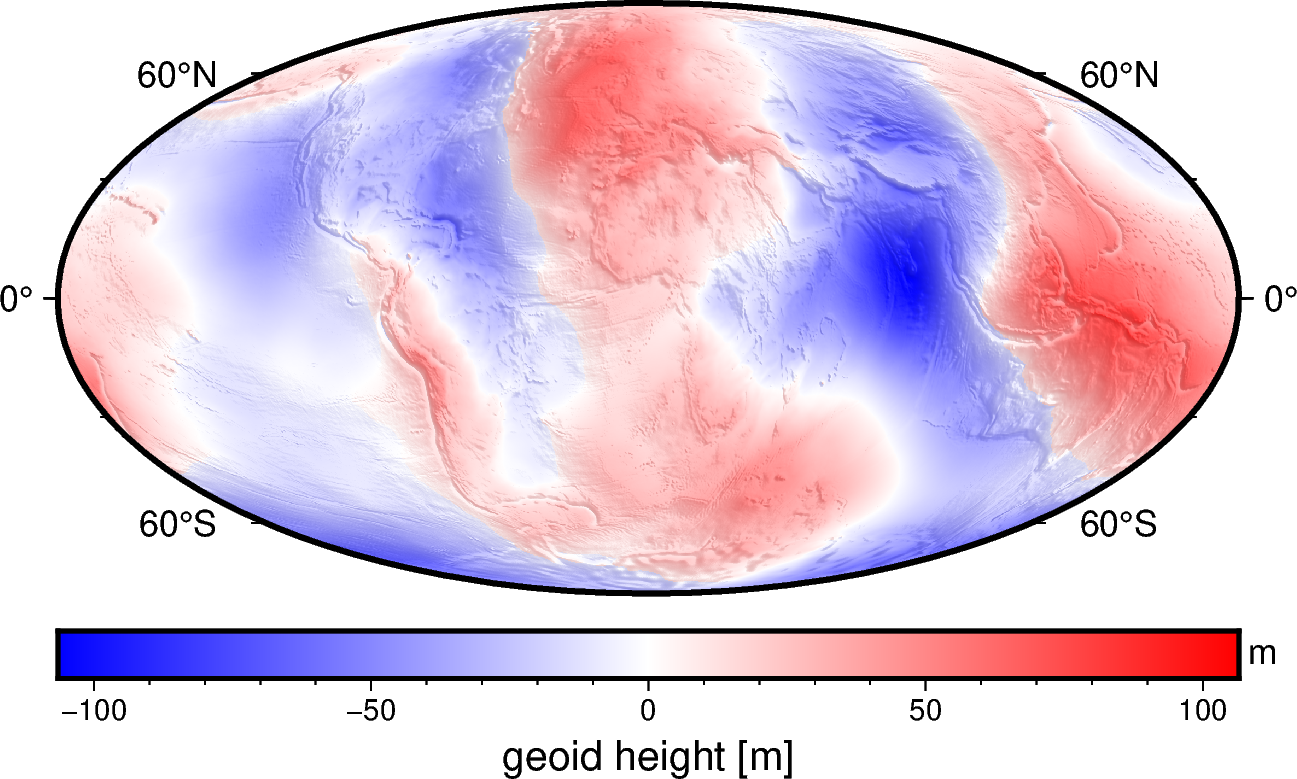

In [7]:
fig = pygmt.Figure()
maxabs = vd.maxabs(geoid)
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    geoid,
    projection="W10c",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"m"', 'x+l"geoid height [m]"'],
)
fig.show()

## Cut datasets to the Bushveld Igneous Complex

In [8]:
region = (25, 32, -28, -23)

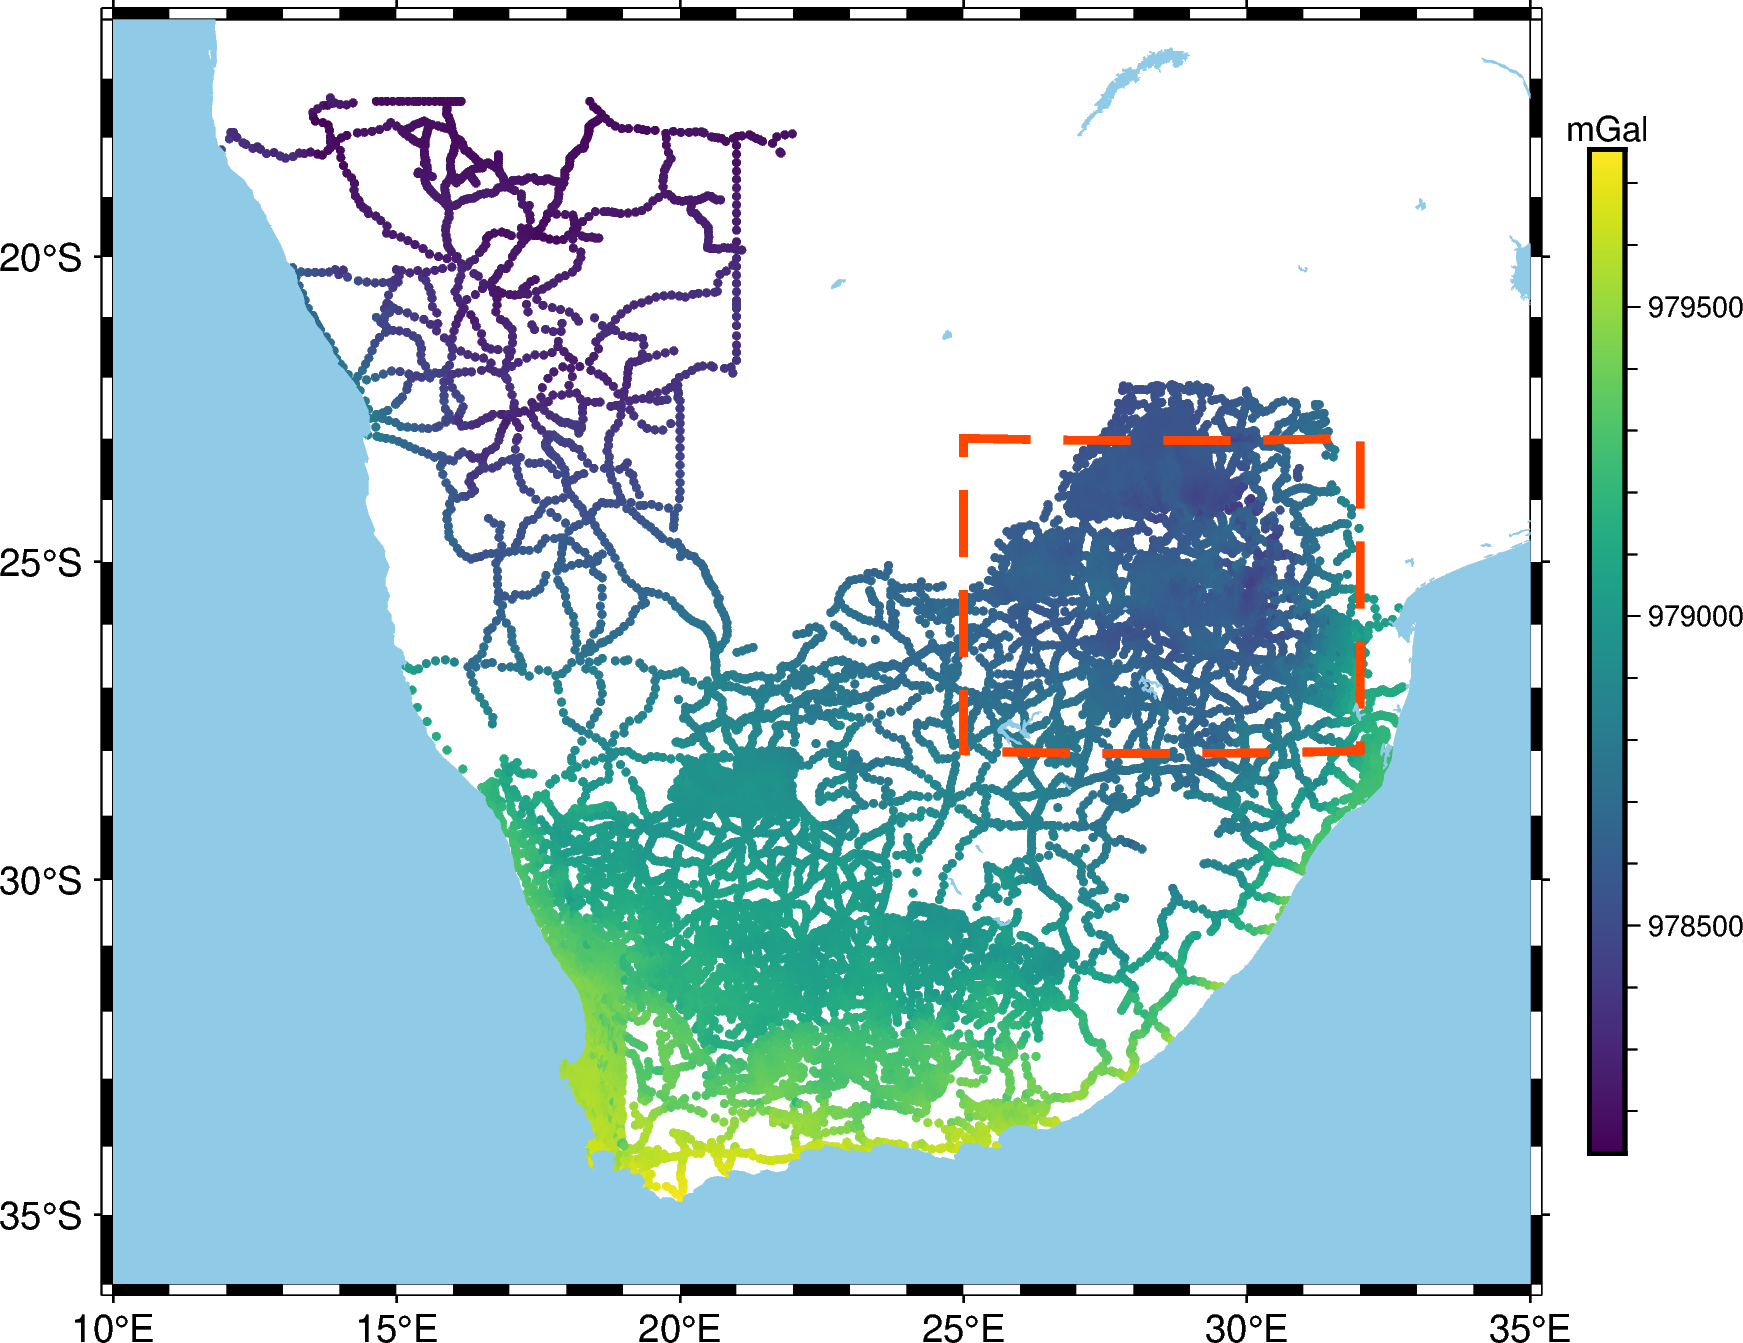

In [9]:
fig = pygmt.Figure()
vmin, vmax = data.gravity_mgal.min(), data.gravity_mgal.max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_mgal,
    cmap=True,
    style="c2p",
    projection=gmt_projection,
    frame="af",
)
fig.plot(
    x=[region[0], region[1], region[1], region[0], region[0]],
    y=[region[3], region[3], region[2], region[2], region[3]],
    pen="2p,orangered1,-",
)
fig.coast(water="#8fcae7")
fig.colorbar(position="JMR+o0.5c/0c+w8.5c/0.3c", frame=["af", 'y+l"mGal"'])
fig.show()

In [10]:
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
data

longitude  latitude  height_sea_level_m  gravity_mgal
7478    25.43668 -27.67833              1227.4     978783.95
7479    25.83000 -27.41667              1287.5     978744.16
7480    25.00000 -27.87167              1258.5     978786.05
7481    25.03168 -27.06168              1255.2     978757.56
7482    25.05000 -27.25166              1302.1     978724.47
...          ...       ...                 ...           ...
12974   31.51500 -23.86333               300.5     978776.85
12975   31.52499 -23.30000               280.7     978798.55
12976   31.54832 -23.19333               245.7     978803.55
12977   31.57333 -23.84833               226.8     978808.44
13557   31.37500 -23.00000               285.6     978734.77

[4569 rows x 4 columns]

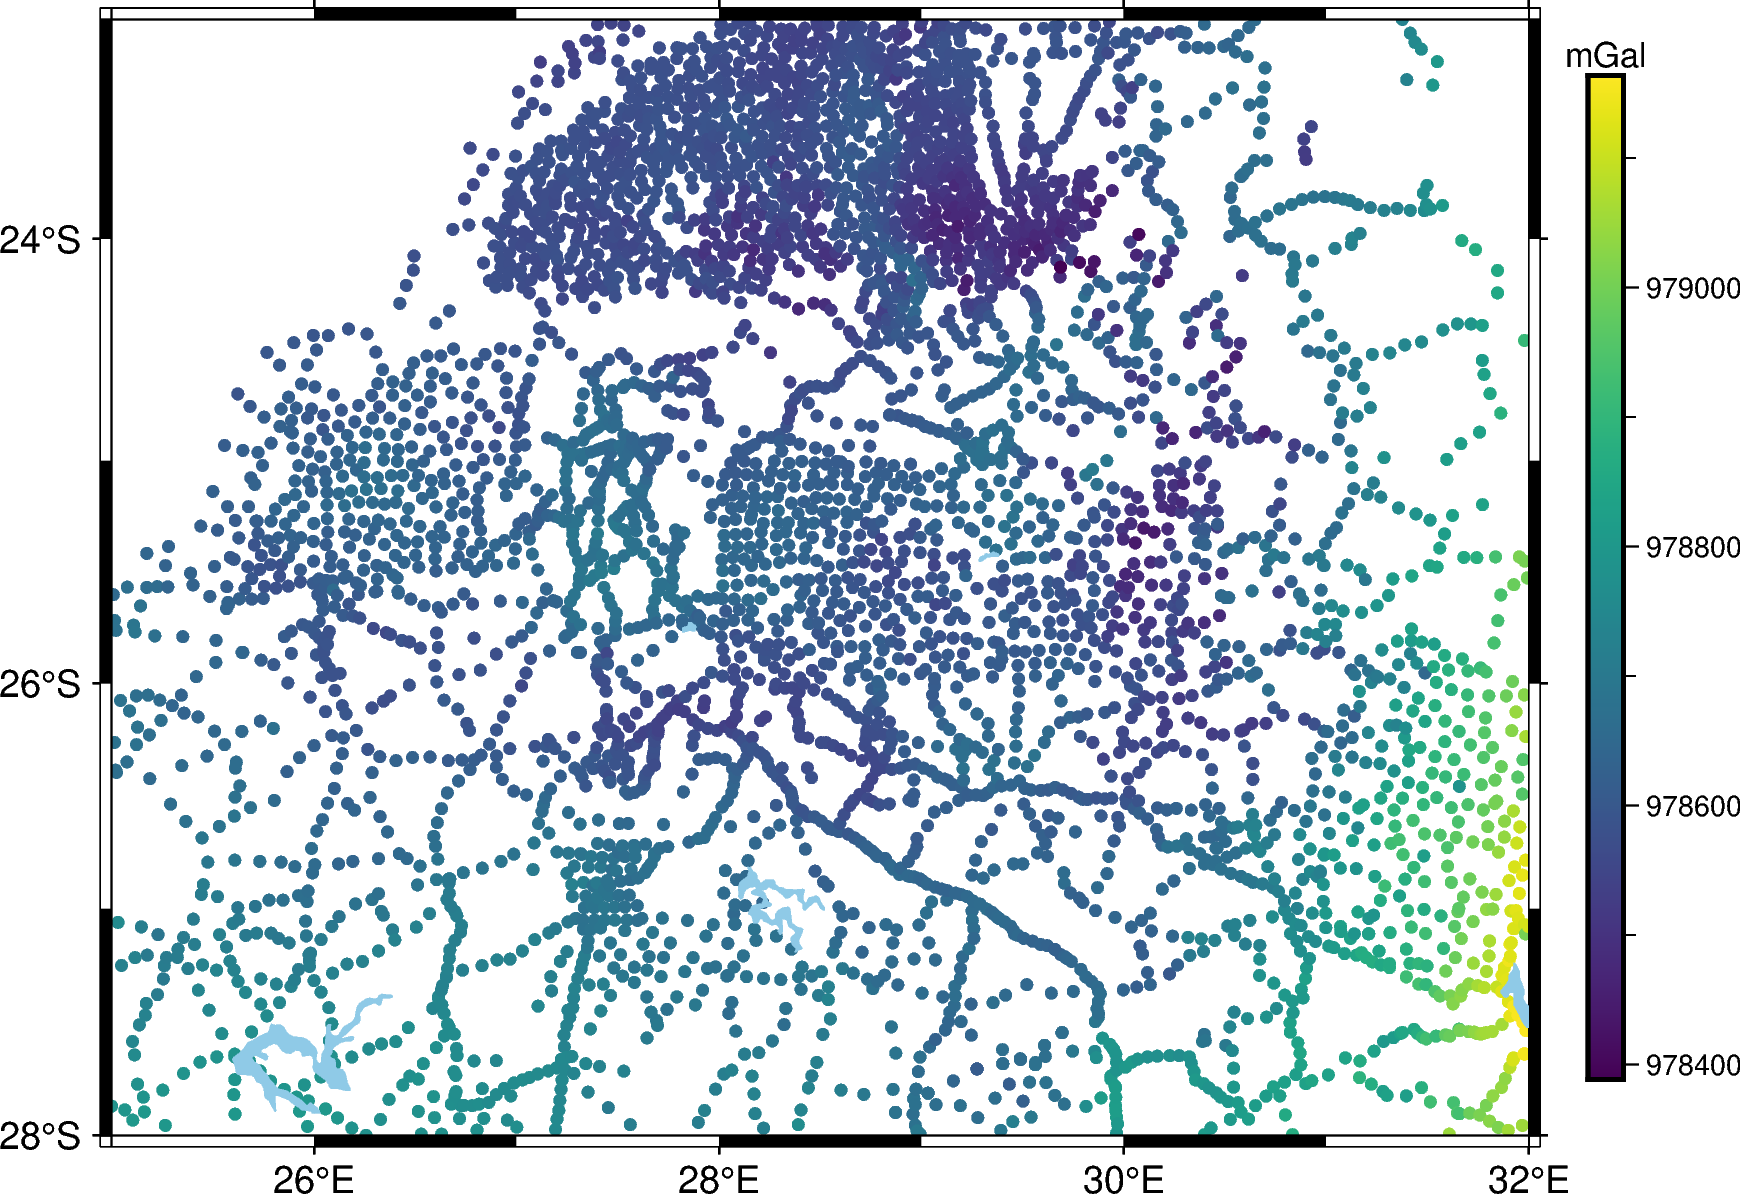

In [11]:
fig = pygmt.Figure()
vmin, vmax = data.gravity_mgal.min(), data.gravity_mgal.max()
pygmt.makecpt(cmap="viridis", series=[vmin, vmax])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_mgal,
    cmap=True,
    style="c3p",
    projection=gmt_projection,
    frame="af",
)
fig.coast(water="#8fcae7")
fig.colorbar(position="JMR+o0.5c/0c+w8.5c/0.3c", frame=["af", 'y+l"mGal"'])
fig.show()

In [12]:
region_pad = vd.pad_region(region, pad=5)
region_pad

(20, 37, -33, -18)

In [13]:
geoid = geoid.sel(longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:]))
geoid

<xarray.DataArray 'geoid' (latitude: 91, longitude: 103)> Size: 75kB
array([[33.9, 34.1, 34.4, ..., 23.2, 22.6, 22.2],
       [33.8, 34.1, 34.4, ..., 22.9, 22.3, 21.9],
       [33.5, 33.9, 34.5, ..., 22.6, 22. , 21.5],
       ...,
       [18.6, 18.1, 17.5, ..., -8.4, -8.2, -8. ],
       [18.1, 17.7, 17.1, ..., -8.9, -8.7, -8.4],
       [17.6, 17.2, 16.7, ..., -9.3, -9.1, -8.8]])
Coordinates:
  * longitude  (longitude) float64 824B 20.0 20.17 20.33 ... 36.67 36.83 37.0
  * latitude   (latitude) float64 728B -33.0 -32.83 -32.67 ... -18.17 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

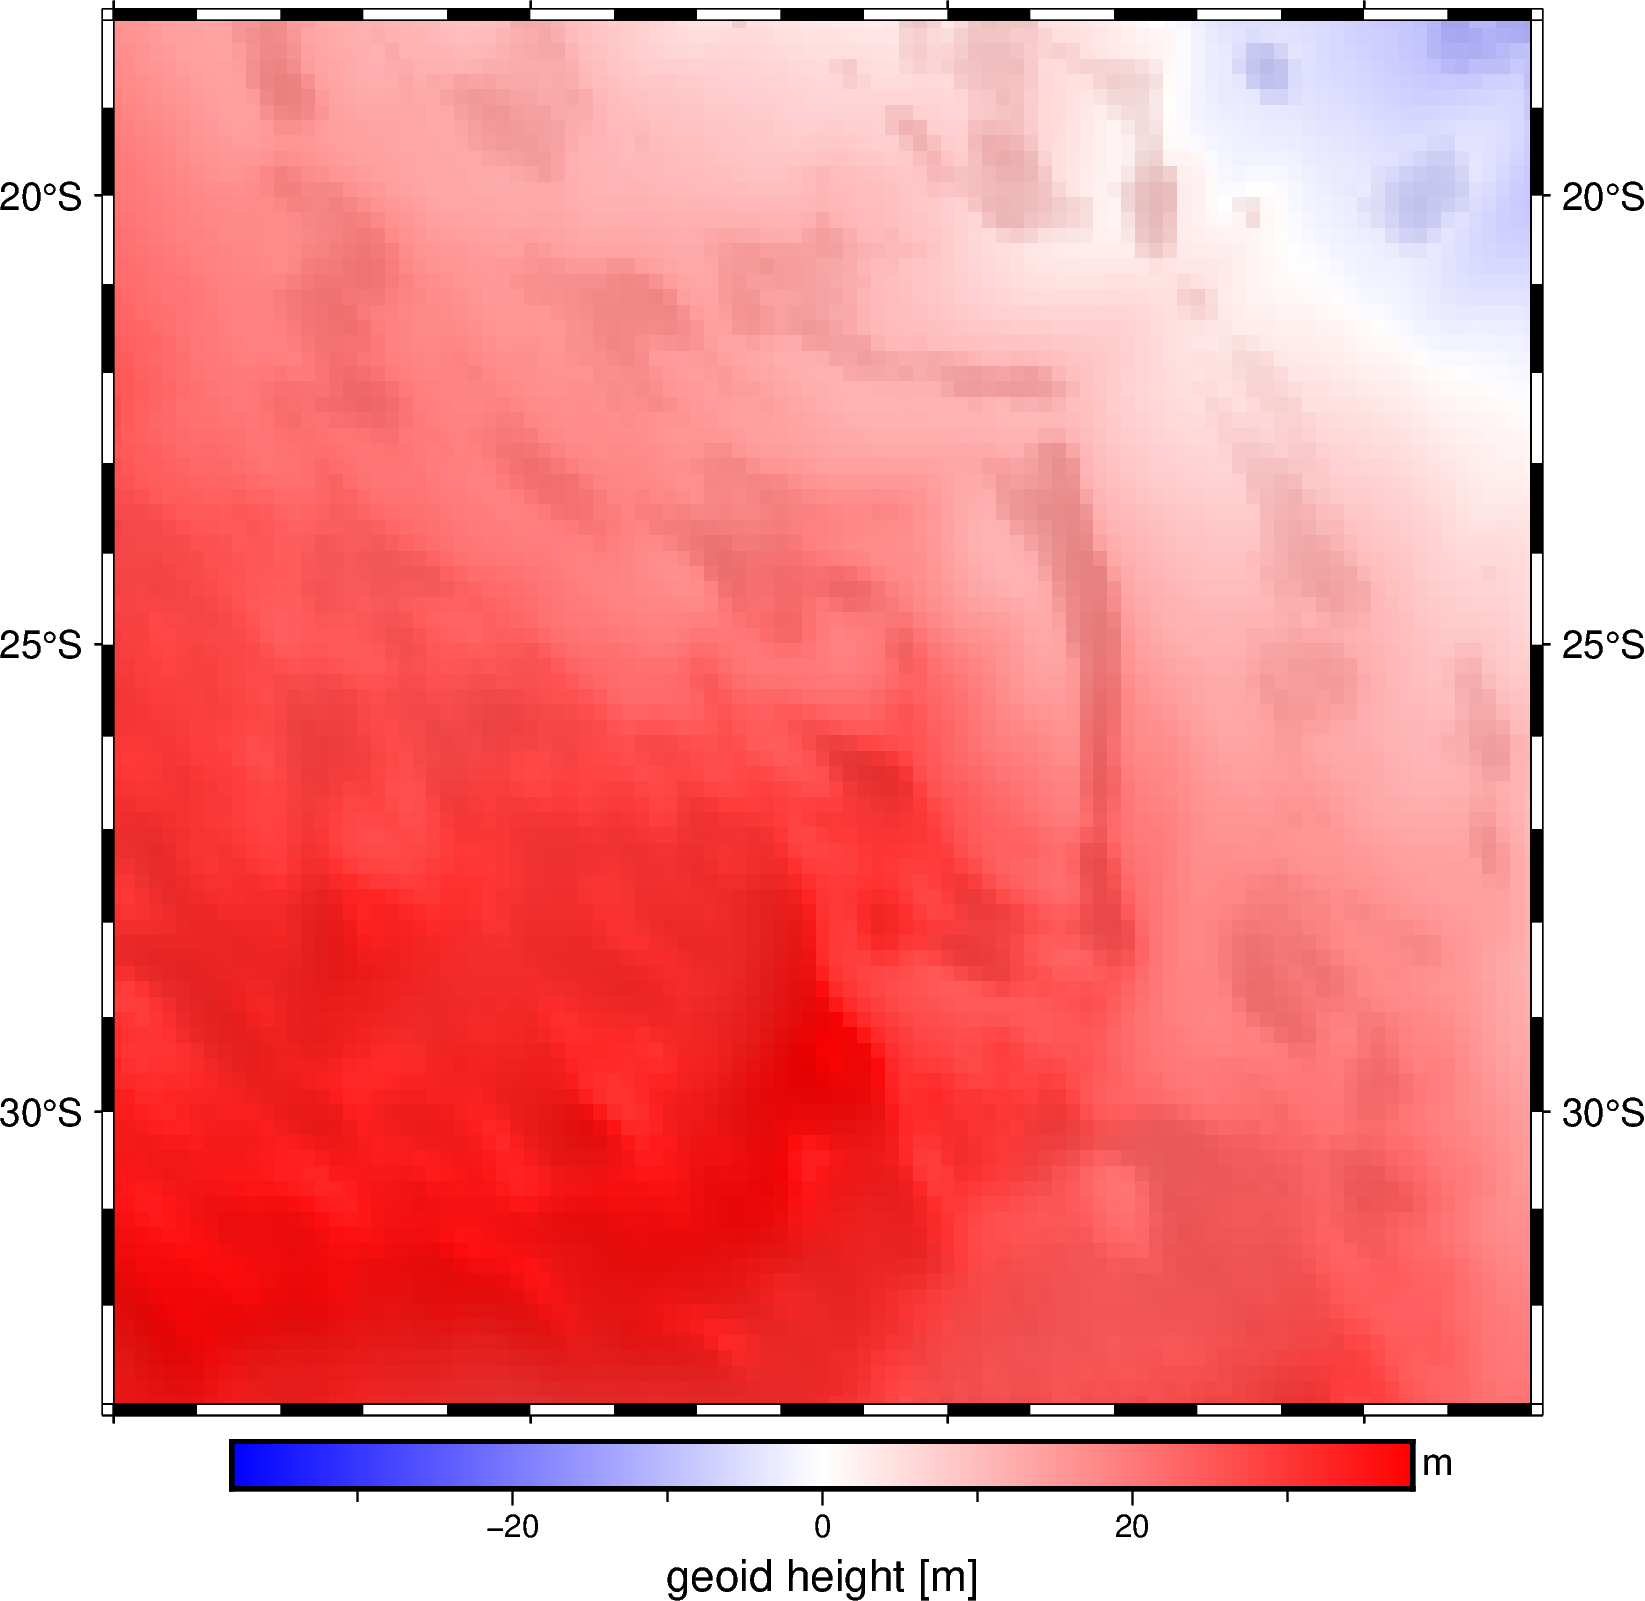

In [14]:
fig = pygmt.Figure()
maxabs = vd.maxabs(geoid)
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    geoid,
    projection=gmt_projection,
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"m"', 'x+l"geoid height [m]"'],
)
fig.show()

## Project geographic data and get ellipsoidal heights

In [15]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [16]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data

longitude  latitude  height_sea_level_m  gravity_mgal     easting_m  \
7478    25.43668 -27.67833              1227.4     978783.95  2.560755e+06   
7479    25.83000 -27.41667              1287.5     978744.16  2.600351e+06   
7480    25.00000 -27.87167              1258.5     978786.05  2.516794e+06   
7481    25.03168 -27.06168              1255.2     978757.56  2.519983e+06   
7482    25.05000 -27.25166              1302.1     978724.47  2.521827e+06   
...          ...       ...                 ...           ...           ...   
12974   31.51500 -23.86333               300.5     978776.85  3.172670e+06   
12975   31.52499 -23.30000               280.7     978798.55  3.173676e+06   
12976   31.54832 -23.19333               245.7     978803.55  3.176024e+06   
12977   31.57333 -23.84833               226.8     978808.44  3.178542e+06   
13557   31.37500 -23.00000               285.6     978734.77  3.158576e+06   

         northing_m  
7478  -2.883642e+06  
7479  -2.854088e+06  
7480  -2.905525e+06  
7481  -2.814106e+06  
7482  -2.835487e+06  
...             ...  
12974 -2.459364e+06  
12975 -2.397833e+06  
12976 -2.386211e+06  
12977 -2.457722e+06  
13557 -2.365172e+06  

[4569 rows x 6 columns]

In [17]:
geoid_proj = vd.project_grid(geoid, projection, method="nearest")
geoid_proj

/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:177: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  columns = {"data{}".format(i): comp.ravel() for i, comp in enumerate(data)}
/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x7f99645409a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function mean at 0x7f99645409a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callab

<xarray.DataArray 'geoid' (northing: 91, easting: 103)> Size: 75kB
array([[34.  , 34.  , 34.4 , ..., 23.6 , 22.6 , 22.2 ],
       [33.95, 33.95, 34.4 , ..., 23.35, 22.3 , 21.9 ],
       [33.7 , 33.7 , 34.5 , ..., 23.05, 22.  , 21.5 ],
       ...,
       [18.35, 18.35, 17.5 , ..., -8.5 , -8.2 , -8.  ],
       [17.65, 17.65, 16.9 , ..., -9.2 , -8.9 , -8.6 ],
       [17.65, 17.65, 16.9 , ..., -9.2 , -8.9 , -8.6 ]])
Coordinates:
  * easting   (easting) float64 824B 2.013e+06 2.03e+06 ... 3.708e+06 3.725e+06
  * northing  (northing) float64 728B -3.502e+06 -3.483e+06 ... -1.831e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

In [18]:
# Unravel the grid so that we can pass it to the interpolator
geoid_table = vd.grid_to_table(geoid_proj)
interpolator = vd.Cubic()
interpolator.fit((geoid_table.easting, geoid_table.northing), geoid_table.geoid)

# Predict the geoid height at same locations as the observation points
data = data.assign(geoid_m=interpolator.predict((data.easting_m, data.northing_m)))
data = data.assign(height_geometric_m=data.height_sea_level_m + data.geoid_m)
data

longitude  latitude  height_sea_level_m  gravity_mgal     easting_m  \
7478    25.43668 -27.67833              1227.4     978783.95  2.560755e+06   
7479    25.83000 -27.41667              1287.5     978744.16  2.600351e+06   
7480    25.00000 -27.87167              1258.5     978786.05  2.516794e+06   
7481    25.03168 -27.06168              1255.2     978757.56  2.519983e+06   
7482    25.05000 -27.25166              1302.1     978724.47  2.521827e+06   
...          ...       ...                 ...           ...           ...   
12974   31.51500 -23.86333               300.5     978776.85  3.172670e+06   
12975   31.52499 -23.30000               280.7     978798.55  3.173676e+06   
12976   31.54832 -23.19333               245.7     978803.55  3.176024e+06   
12977   31.57333 -23.84833               226.8     978808.44  3.178542e+06   
13557   31.37500 -23.00000               285.6     978734.77  3.158576e+06   

         northing_m    geoid_m  height_geometric_m  
7478  -2.883642e+06  29.985661         1257.385661  
7479  -2.854088e+06  29.614339         1317.114339  
7480  -2.905525e+06  29.980263         1288.480263  
7481  -2.814106e+06  29.296646         1284.496646  
7482  -2.835487e+06  29.414196         1331.514196  
...             ...        ...                 ...  
12974 -2.459364e+06  12.217216          312.717216  
12975 -2.397833e+06  11.986752          292.686752  
12976 -2.386211e+06  11.901848          257.601848  
12977 -2.457722e+06  12.405262          239.205262  
13557 -2.365172e+06  11.561308          297.161308  

[4569 rows x 8 columns]

## Compute gravity disturbance

In [19]:
ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_geometric_m)

In [20]:
disturbance = data.gravity_mgal - normal_gravity
data = data.assign(disturbance_mgal=disturbance)
data

longitude  latitude  height_sea_level_m  gravity_mgal     easting_m  \
7478    25.43668 -27.67833              1227.4     978783.95  2.560755e+06   
7479    25.83000 -27.41667              1287.5     978744.16  2.600351e+06   
7480    25.00000 -27.87167              1258.5     978786.05  2.516794e+06   
7481    25.03168 -27.06168              1255.2     978757.56  2.519983e+06   
7482    25.05000 -27.25166              1302.1     978724.47  2.521827e+06   
...          ...       ...                 ...           ...           ...   
12974   31.51500 -23.86333               300.5     978776.85  3.172670e+06   
12975   31.52499 -23.30000               280.7     978798.55  3.173676e+06   
12976   31.54832 -23.19333               245.7     978803.55  3.176024e+06   
12977   31.57333 -23.84833               226.8     978808.44  3.178542e+06   
13557   31.37500 -23.00000               285.6     978734.77  3.158576e+06   

         northing_m    geoid_m  height_geometric_m  disturbance_mgal  
7478  -2.883642e+06  29.985661         1257.385661         24.356094  
7479  -2.854088e+06  29.614339         1317.114339         22.367995  
7480  -2.905525e+06  29.980263         1288.480263         21.652832  
7481  -2.814106e+06  29.296646         1284.496646         51.792160  
7482  -2.835487e+06  29.414196         1331.514196         19.275017  
...             ...        ...                 ...               ...  
12974 -2.459364e+06  12.217216          312.717216         -4.781812  
12975 -2.397833e+06  11.986752          292.686752         48.012804  
12976 -2.386211e+06  11.901848          257.601848         49.164604  
12977 -2.457722e+06  12.405262          239.205262          5.118817  
13557 -2.365172e+06  11.561308          297.161308          5.185579  

[4569 rows x 9 columns]

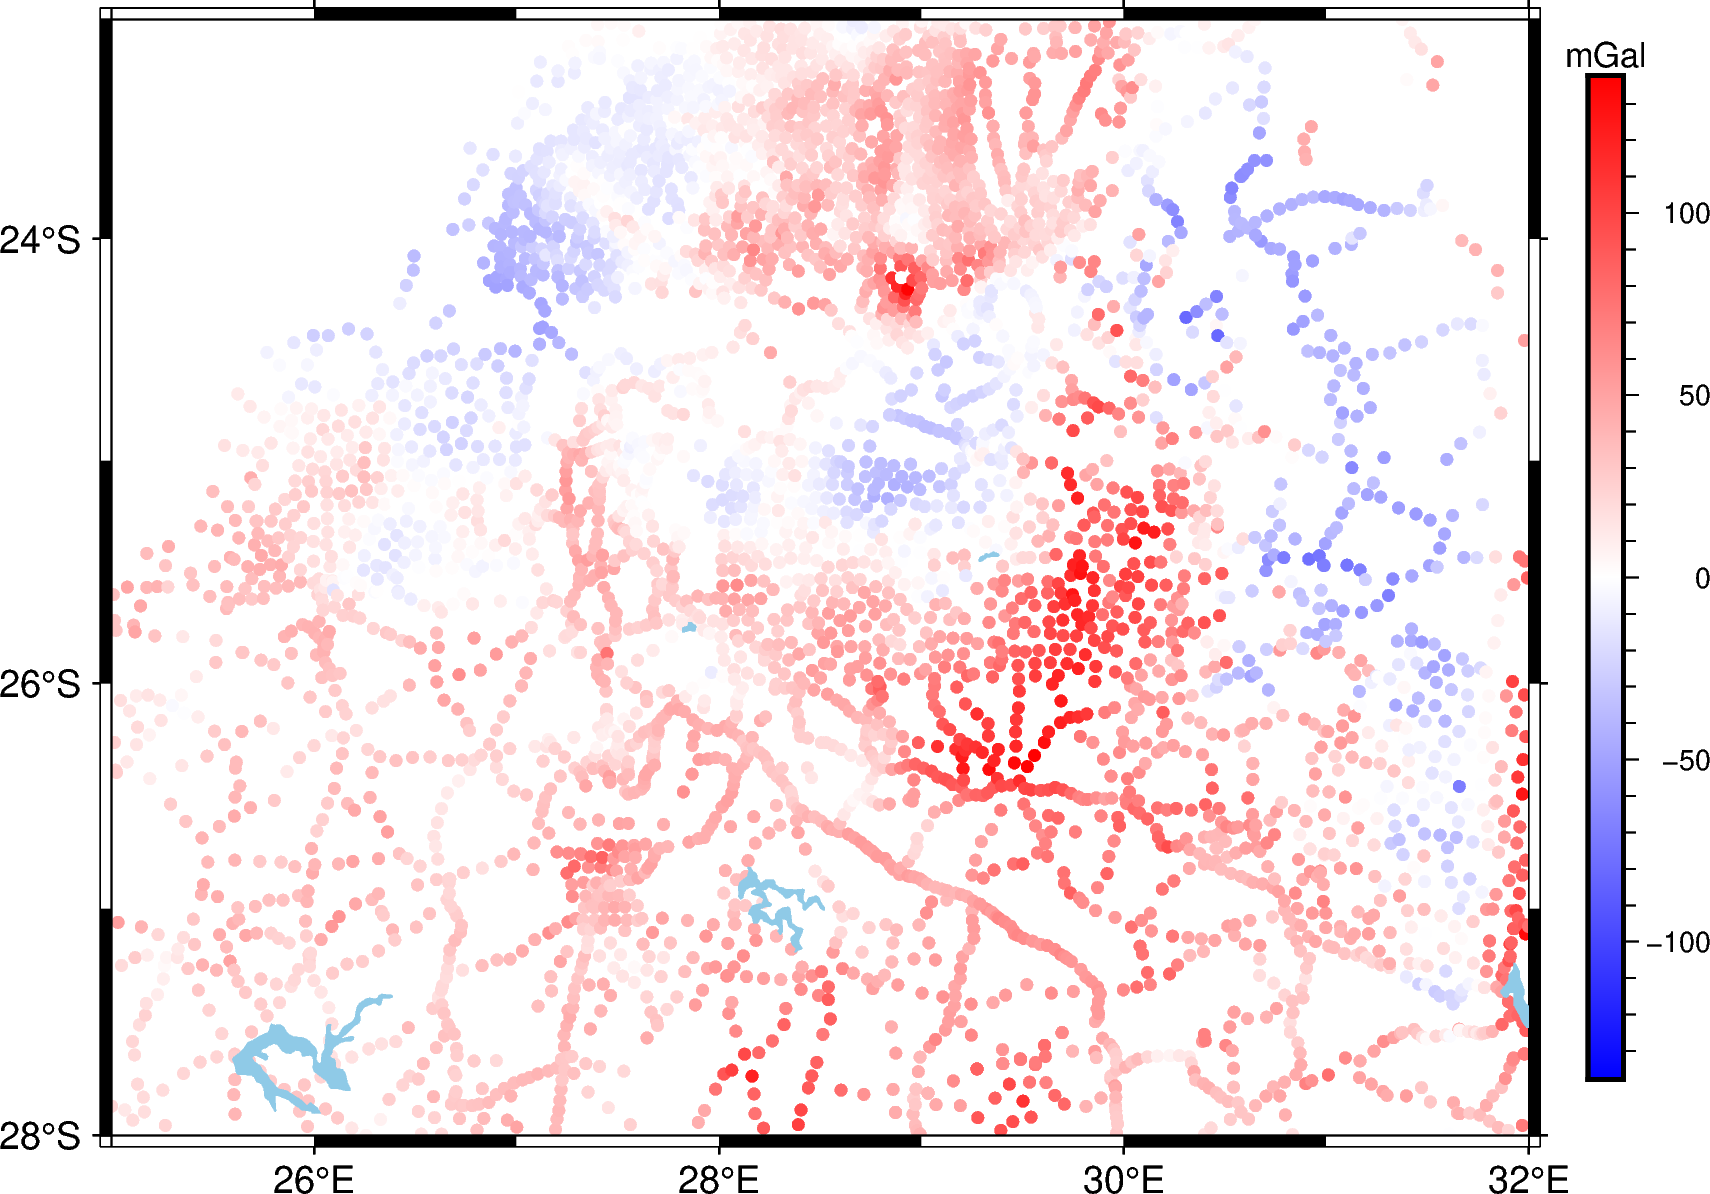

In [21]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.disturbance_mgal,
    cmap=True,
    style="c3p",
    projection=gmt_projection,
    frame="af",
)
fig.coast(water="#8fcae7")
fig.colorbar(position="JMR+o0.5c/0c+w8.5c/0.3c", frame=["af", 'y+l"mGal"'])
fig.show()

## Terrain correction

In [22]:
fname = ensaio.fetch_earth_topography(version=1)
topography = xr.load_dataarray(fname)
topography

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)> Size: 19MB
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]])
Coordinates:
  * longitude  (longitude) float64 17kB -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude   (latitude) float64 9kB -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

In [23]:
topography = topography.sel(
    longitude=slice(*region_pad[:2]), latitude=slice(*region_pad[2:])
)
topography

<xarray.DataArray 'topography' (latitude: 91, longitude: 103)> Size: 75kB
array([[  616.,   807.,   993., ..., -4607., -4985., -5030.],
       [  656.,   806.,   918., ..., -4490., -4945., -4997.],
       [  564.,   700.,   836., ..., -4428., -4874., -4910.],
       ...,
       [ 1128.,  1123.,  1113., ...,    -7.,   -32.,   -18.],
       [ 1115.,  1107.,  1098., ...,    17.,   -10.,   -21.],
       [ 1102.,  1094.,  1084., ...,    18.,     9.,   -13.]])
Coordinates:
  * longitude  (longitude) float64 824B 20.0 20.17 20.33 ... 36.67 36.83 37.0
  * latitude   (latitude) float64 728B -33.0 -32.83 -32.67 ... -18.17 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

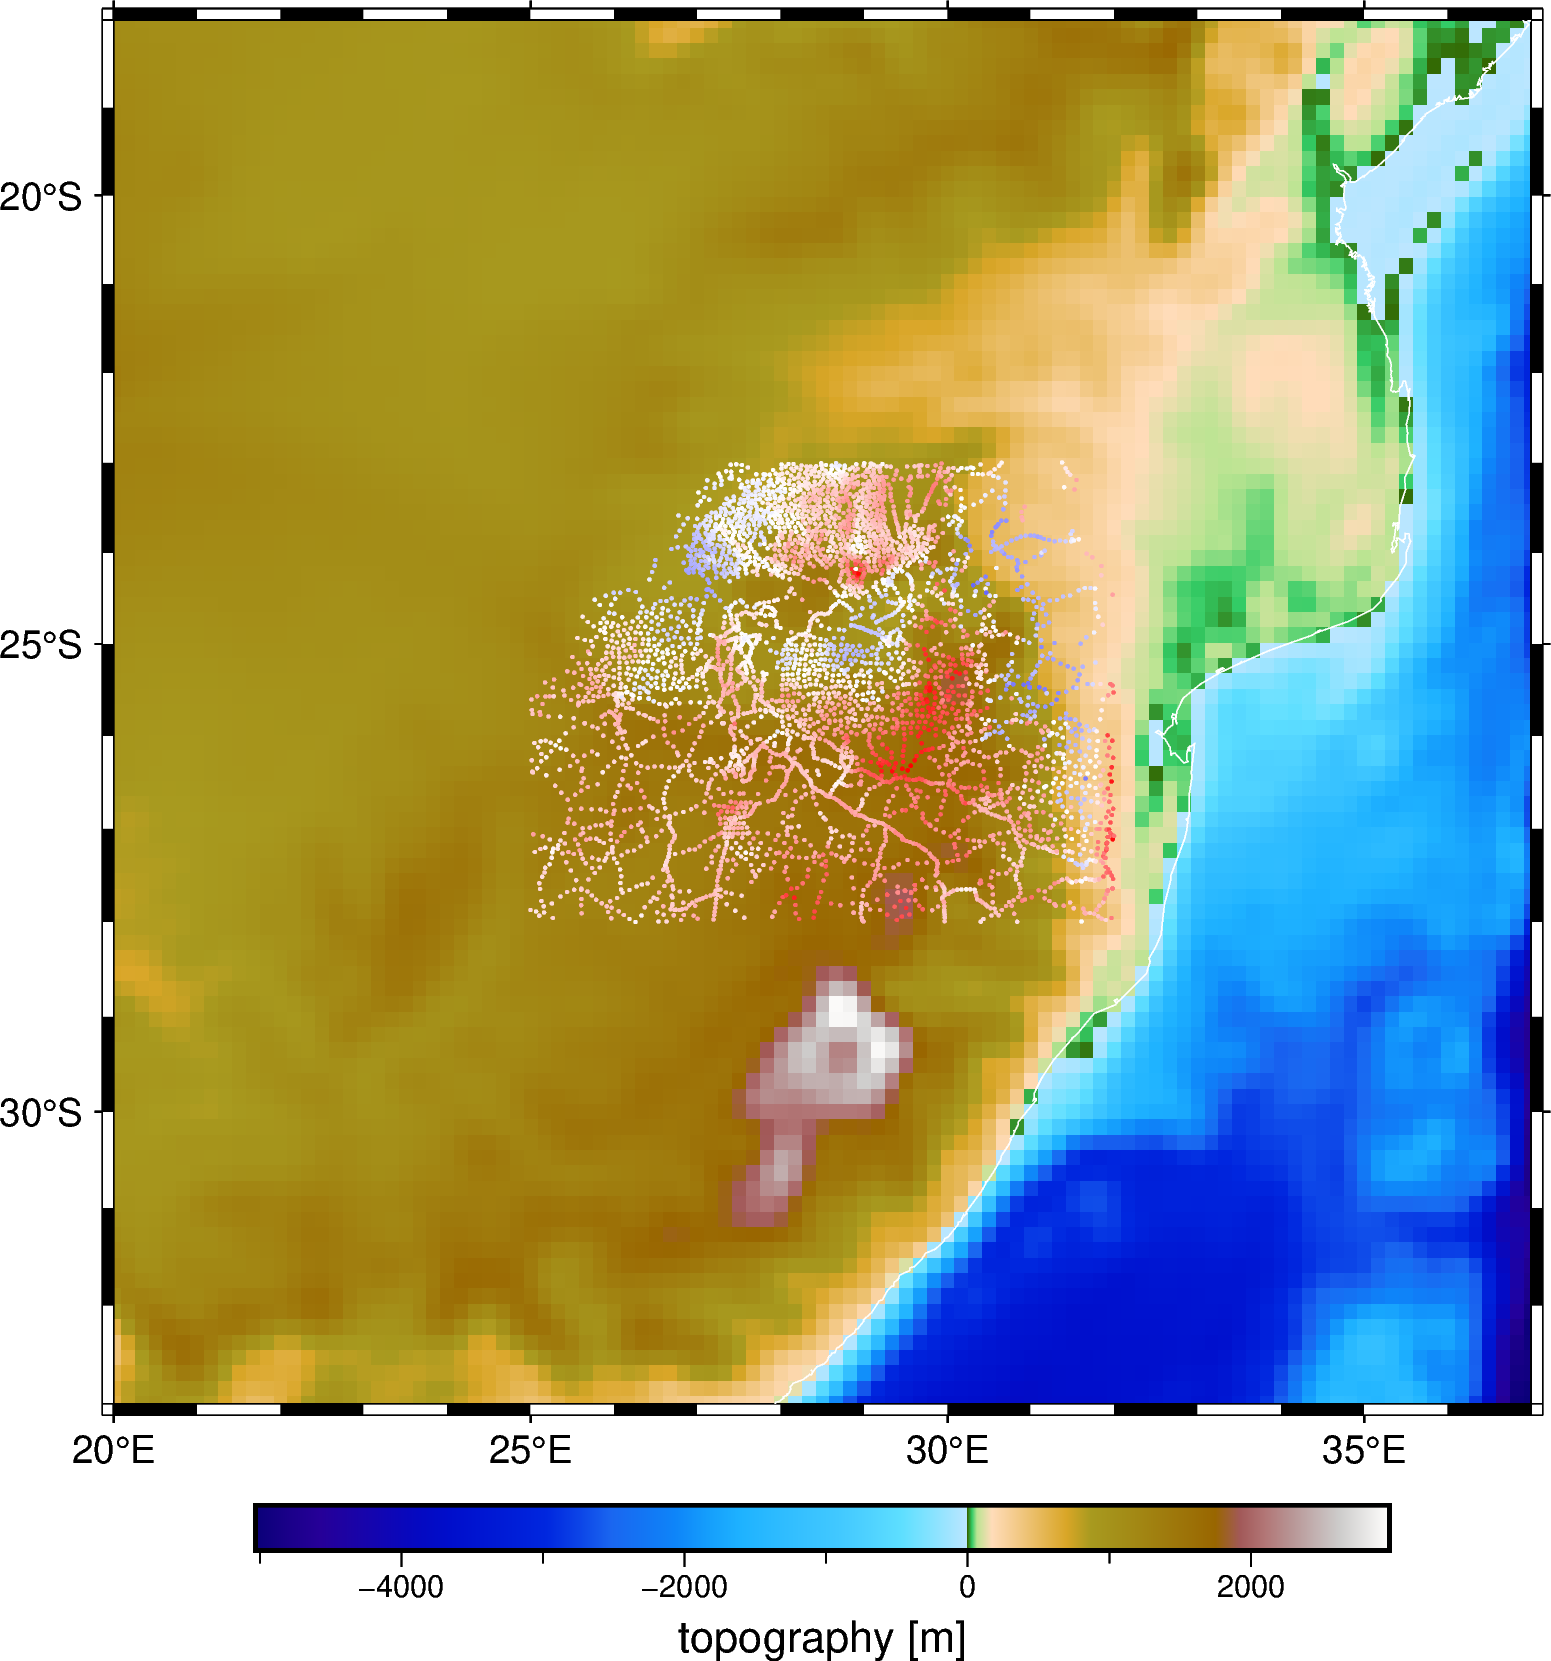

In [24]:
fig = pygmt.Figure()
fig.grdimage(topography, projection=gmt_projection, cmap="etopo1", frame=True)
fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines="white", area_thresh=1e6)

maxabs = vd.maxabs(data.disturbance_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.disturbance_mgal,
    cmap=True,
    style="c1p",
    projection=gmt_projection,
)

fig.show()

In [25]:
topography_proj = vd.project_grid(topography, projection, method="nearest")
topography_proj

/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:177: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  columns = {"data{}".format(i): comp.ravel() for i, comp in enumerate(data)}
/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x7f99645409a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function mean at 0x7f99645409a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callab

<xarray.DataArray 'topography' (northing: 91, easting: 103)> Size: 75kB
array([[ 7.1150e+02,  7.1150e+02,  9.9300e+02, ..., -4.1875e+03,
        -4.9850e+03, -5.0300e+03],
       [ 7.3100e+02,  7.3100e+02,  9.1800e+02, ..., -4.0225e+03,
        -4.9450e+03, -4.9970e+03],
       [ 6.3200e+02,  6.3200e+02,  8.3600e+02, ..., -3.9670e+03,
        -4.8740e+03, -4.9100e+03],
       ...,
       [ 1.1255e+03,  1.1255e+03,  1.1130e+03, ...,  3.5000e+00,
        -3.2000e+01, -1.8000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01]])
Coordinates:
  * easting   (easting) float64 824B 2.013e+06 2.03e+06 ... 3.708e+06 3.725e+06
  * northing  (northing) float64 728B -3.502e+06 -3.483e+06 ... -1.831e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

In [26]:
topography_geometric = topography_proj + geoid_proj
topography_geometric

<xarray.DataArray (northing: 91, easting: 103)> Size: 75kB
array([[ 7.45500e+02,  7.45500e+02,  1.02740e+03, ..., -4.16390e+03,
        -4.96240e+03, -5.00780e+03],
       [ 7.64950e+02,  7.64950e+02,  9.52400e+02, ..., -3.99915e+03,
        -4.92270e+03, -4.97510e+03],
       [ 6.65700e+02,  6.65700e+02,  8.70500e+02, ..., -3.94395e+03,
        -4.85200e+03, -4.88850e+03],
       ...,
       [ 1.14385e+03,  1.14385e+03,  1.13050e+03, ..., -5.00000e+00,
        -4.02000e+01, -2.60000e+01],
       [ 1.12215e+03,  1.12215e+03,  1.10790e+03, ...,  2.55000e+00,
        -9.40000e+00, -2.56000e+01],
       [ 1.12215e+03,  1.12215e+03,  1.10790e+03, ...,  2.55000e+00,
        -9.40000e+00, -2.56000e+01]])
Coordinates:
  * easting   (easting) float64 824B 2.013e+06 2.03e+06 ... 3.708e+06 3.725e+06
  * northing  (northing) float64 728B -3.502e+06 -3.483e+06 ... -1.831e+06

In [27]:
topography_density = np.where(topography_geometric > 0, 2670, 1040 - 2670)

# Create the prism model of the topographic masses
topography_model = hm.prism_layer(
    coordinates=(topography_geometric.easting, topography_geometric.northing),
    surface=topography_geometric,
    reference=0,
    properties={"density": topography_density},
)
topography_model

<xarray.Dataset> Size: 227kB
Dimensions:   (northing: 91, easting: 103)
Coordinates:
  * easting   (easting) float64 824B 2.013e+06 2.03e+06 ... 3.708e+06 3.725e+06
  * northing  (northing) float64 728B -3.502e+06 -3.483e+06 ... -1.831e+06
    top       (northing, easting) float64 75kB 745.5 745.5 1.027e+03 ... 0.0 0.0
    bottom    (northing, easting) float64 75kB 0.0 0.0 0.0 ... 0.0 -9.4 -25.6
Data variables:
    density   (northing, easting) int64 75kB 2670 2670 2670 ... 2670 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

In [28]:
coordinates = (data.easting_m, data.northing_m, data.height_geometric_m)

terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")
bouguer = data.disturbance_mgal - terrain_effect

data = data.assign(terrain_effect_mgal=terrain_effect)
data = data.assign(gravity_bouguer_mgal=bouguer)
data

longitude  latitude  height_sea_level_m  gravity_mgal     easting_m  \
7478    25.43668 -27.67833              1227.4     978783.95  2.560755e+06   
7479    25.83000 -27.41667              1287.5     978744.16  2.600351e+06   
7480    25.00000 -27.87167              1258.5     978786.05  2.516794e+06   
7481    25.03168 -27.06168              1255.2     978757.56  2.519983e+06   
7482    25.05000 -27.25166              1302.1     978724.47  2.521827e+06   
...          ...       ...                 ...           ...           ...   
12974   31.51500 -23.86333               300.5     978776.85  3.172670e+06   
12975   31.52499 -23.30000               280.7     978798.55  3.173676e+06   
12976   31.54832 -23.19333               245.7     978803.55  3.176024e+06   
12977   31.57333 -23.84833               226.8     978808.44  3.178542e+06   
13557   31.37500 -23.00000               285.6     978734.77  3.158576e+06   

         northing_m    geoid_m  height_geometric_m  disturbance_mgal  \
7478  -2.883642e+06  29.985661         1257.385661         24.356094   
7479  -2.854088e+06  29.614339         1317.114339         22.367995   
7480  -2.905525e+06  29.980263         1288.480263         21.652832   
7481  -2.814106e+06  29.296646         1284.496646         51.792160   
7482  -2.835487e+06  29.414196         1331.514196         19.275017   
...             ...        ...                 ...               ...   
12974 -2.459364e+06  12.217216          312.717216         -4.781812   
12975 -2.397833e+06  11.986752          292.686752         48.012804   
12976 -2.386211e+06  11.901848          257.601848         49.164604   
12977 -2.457722e+06  12.405262          239.205262          5.118817   
13557 -2.365172e+06  11.561308          297.161308          5.185579   

       terrain_effect_mgal  gravity_bouguer_mgal  
7478            138.773003           -114.416909  
7479            143.701187           -121.333192  
7480            140.510102           -118.857270  
7481            142.936173            -91.144013  
7482            146.260639           -126.985622  
...                    ...                   ...  
12974            33.838557            -38.620369  
12975            27.421208             20.591596  
12976            20.888132             28.276472  
12977            17.425350            -12.306533  
13557            26.969949            -21.784370  

[4569 rows x 11 columns]

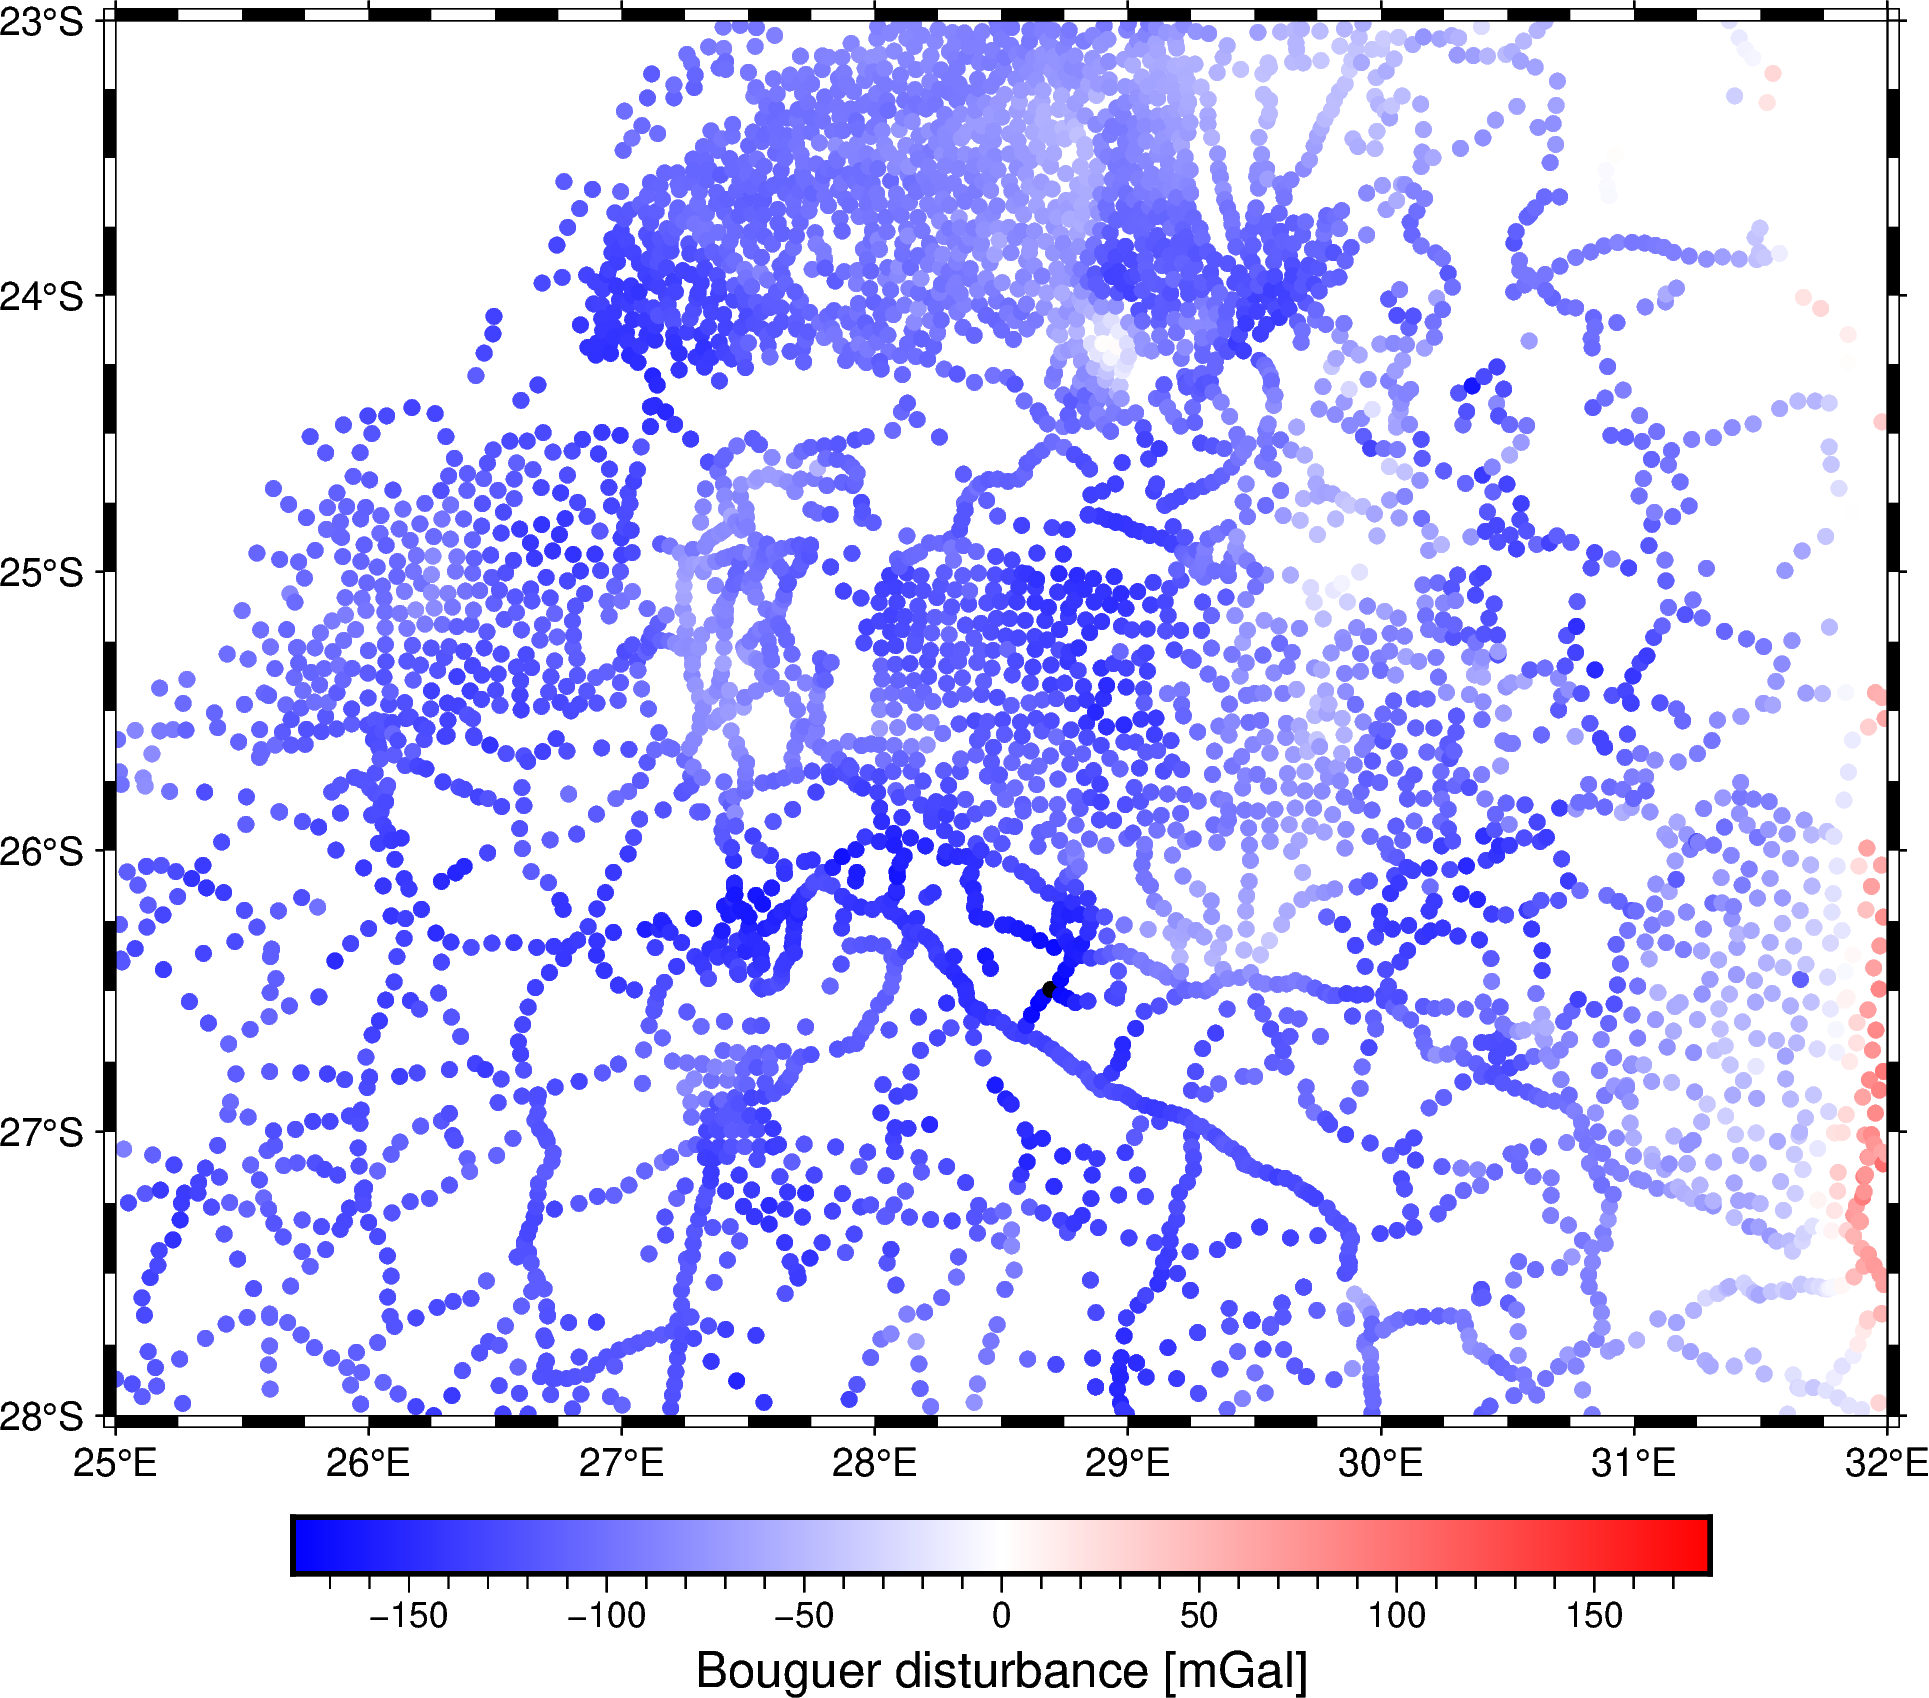

In [29]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_bouguer_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_bouguer_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Bouguer disturbance [mGal]"')
fig.show()

## Get residual

In [30]:
# Create a set of deep sources at a depth of 500 km
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3)

# Fit the sources to the data
deep_sources.fit(
    (data.easting_m, data.northing_m, data.height_geometric_m),
    data.gravity_bouguer_mgal,
)

# Use the sources to predict the regional field
regional = deep_sources.predict(
    (data.easting_m, data.northing_m, data.height_geometric_m)
)

# Calculate a residual field (which is what we want)
residual = data.gravity_bouguer_mgal - regional

data = data.assign(gravity_residual_mgal=residual)
data

/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


longitude  latitude  height_sea_level_m  gravity_mgal     easting_m  \
7478    25.43668 -27.67833              1227.4     978783.95  2.560755e+06   
7479    25.83000 -27.41667              1287.5     978744.16  2.600351e+06   
7480    25.00000 -27.87167              1258.5     978786.05  2.516794e+06   
7481    25.03168 -27.06168              1255.2     978757.56  2.519983e+06   
7482    25.05000 -27.25166              1302.1     978724.47  2.521827e+06   
...          ...       ...                 ...           ...           ...   
12974   31.51500 -23.86333               300.5     978776.85  3.172670e+06   
12975   31.52499 -23.30000               280.7     978798.55  3.173676e+06   
12976   31.54832 -23.19333               245.7     978803.55  3.176024e+06   
12977   31.57333 -23.84833               226.8     978808.44  3.178542e+06   
13557   31.37500 -23.00000               285.6     978734.77  3.158576e+06   

         northing_m    geoid_m  height_geometric_m  disturbance_mgal  \
7478  -2.883642e+06  29.985661         1257.385661         24.356094   
7479  -2.854088e+06  29.614339         1317.114339         22.367995   
7480  -2.905525e+06  29.980263         1288.480263         21.652832   
7481  -2.814106e+06  29.296646         1284.496646         51.792160   
7482  -2.835487e+06  29.414196         1331.514196         19.275017   
...             ...        ...                 ...               ...   
12974 -2.459364e+06  12.217216          312.717216         -4.781812   
12975 -2.397833e+06  11.986752          292.686752         48.012804   
12976 -2.386211e+06  11.901848          257.601848         49.164604   
12977 -2.457722e+06  12.405262          239.205262          5.118817   
13557 -2.365172e+06  11.561308          297.161308          5.185579   

       terrain_effect_mgal  gravity_bouguer_mgal  gravity_residual_mgal  
7478            138.773003           -114.416909               2.119774  
7479            143.701187           -121.333192              -2.608211  
7480            140.510102           -118.857270              -5.125028  
7481            142.936173            -91.144013              25.061505  
7482            146.260639           -126.985622             -11.198659  
...                    ...                   ...                    ...  
12974            33.838557            -38.620369              16.893601  
12975            27.421208             20.591596              69.920811  
12976            20.888132             28.276472              75.996606  
12977            17.425350            -12.306533              41.722936  
13557            26.969949            -21.784370              26.477548  

[4569 rows x 12 columns]

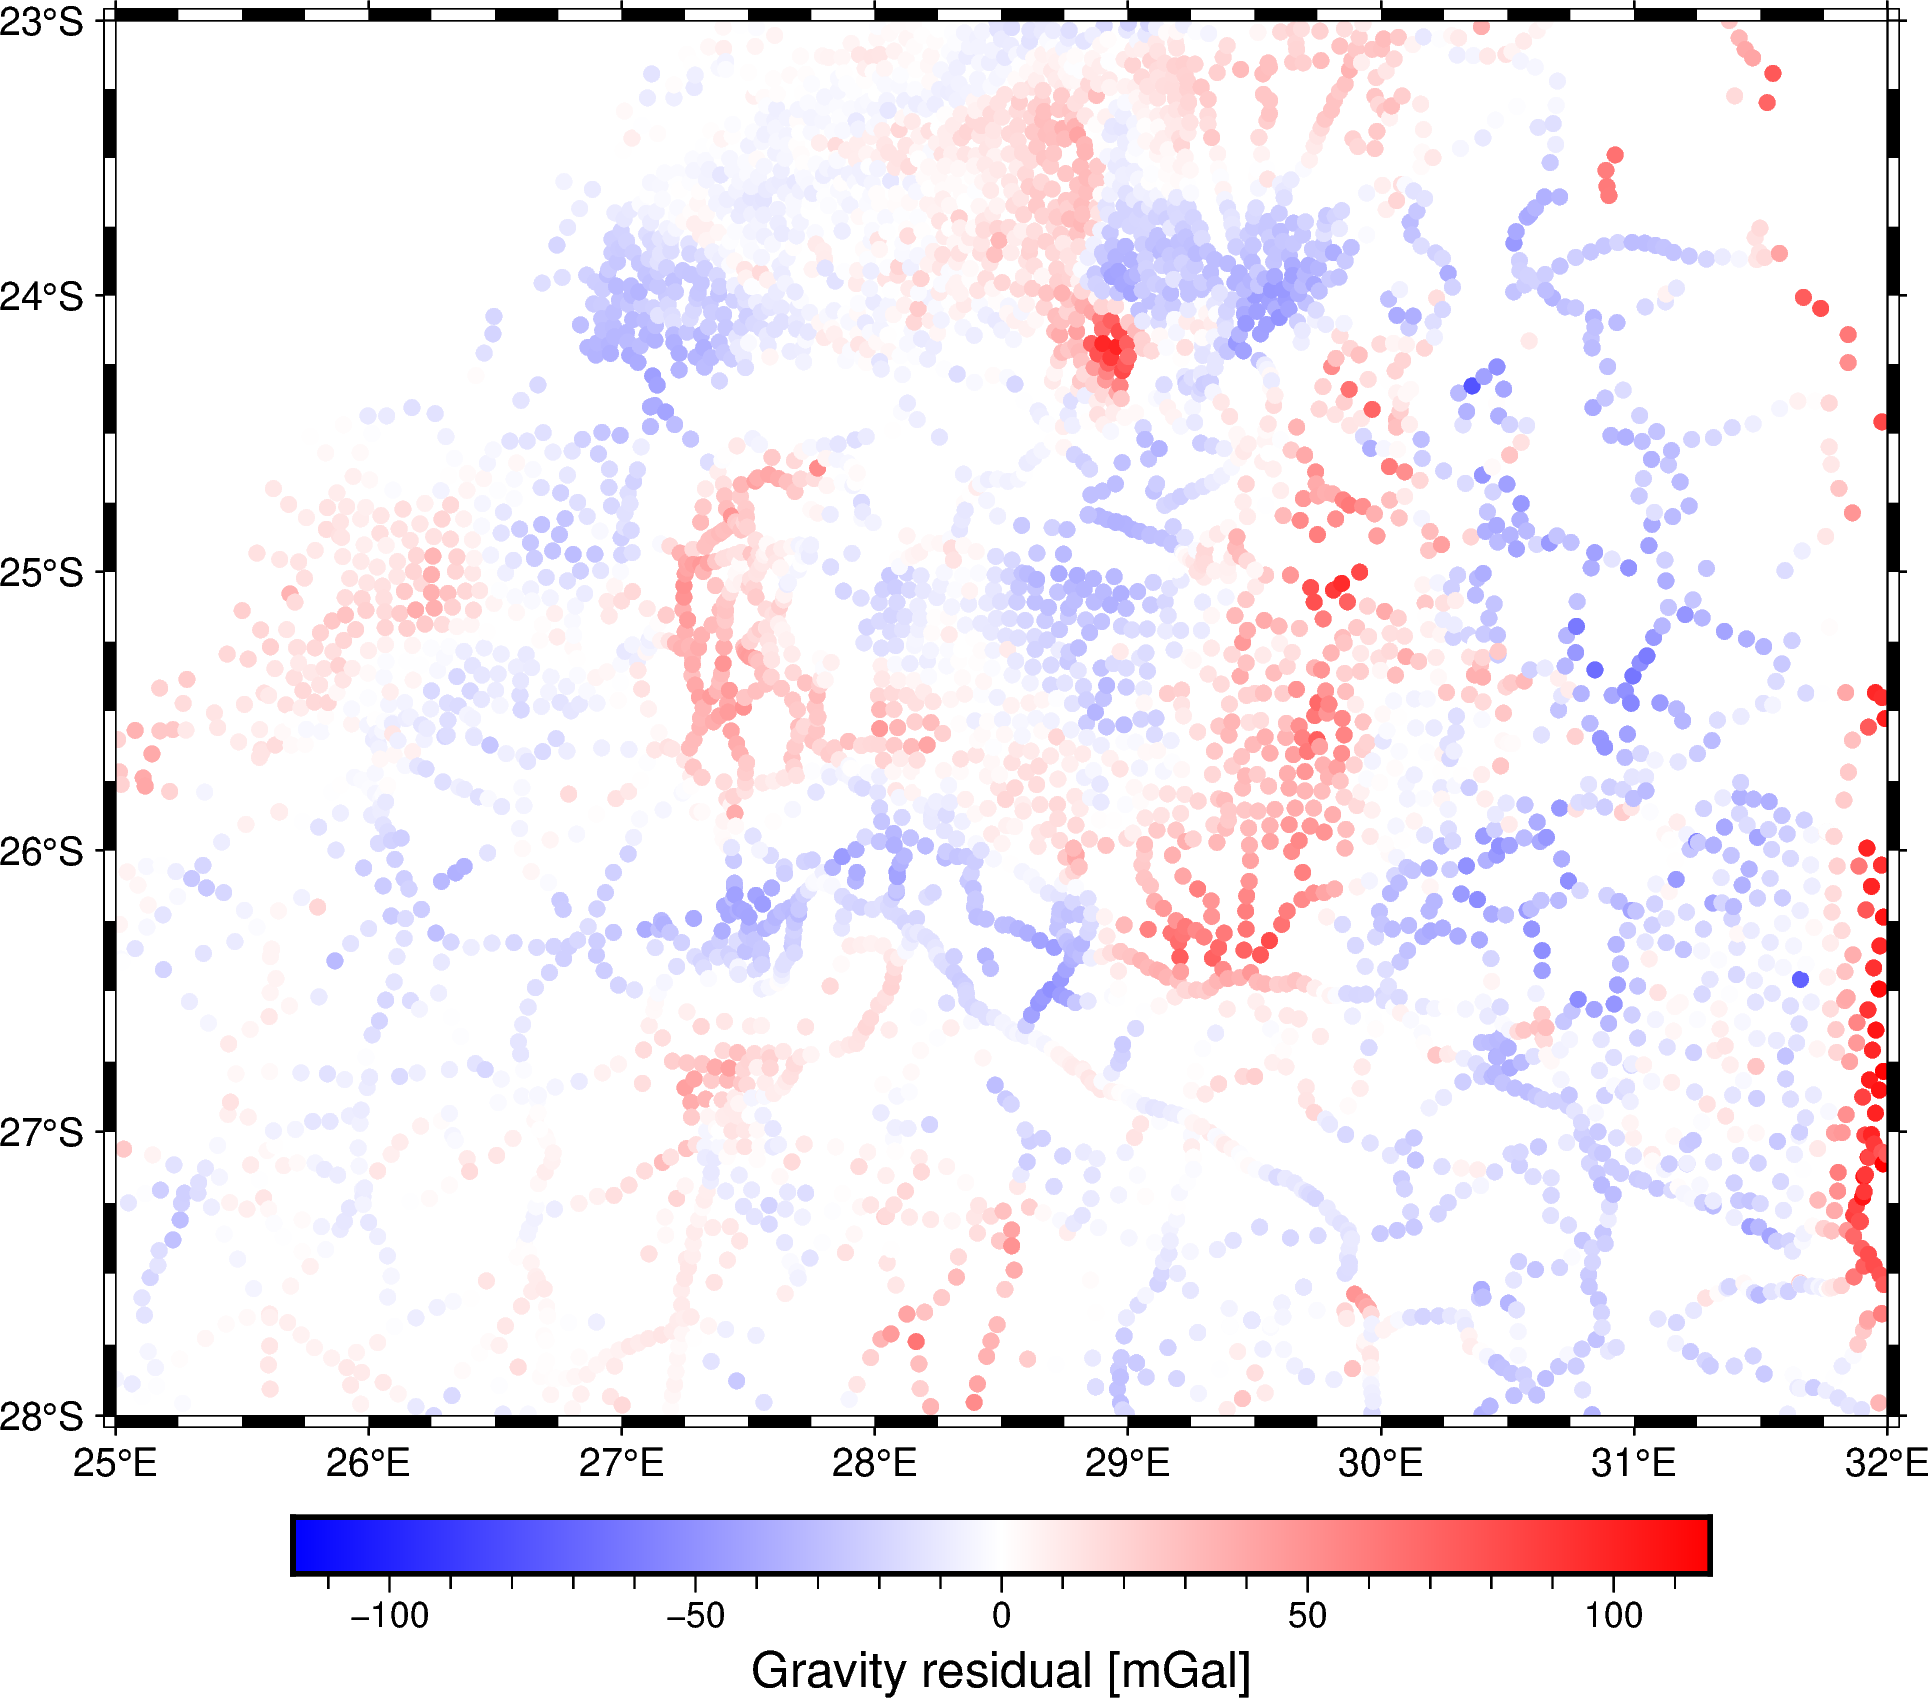

In [31]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.gravity_residual_mgal)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_residual_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"Gravity residual [mGal]"')
fig.show()

## Grid

In [32]:
eqs = hm.EquivalentSources(damping=10, depth=10e3)
eqs.fit(coordinates, data.gravity_residual_mgal)

/home/santi/.mambaforge/envs/2024-uh/lib/python3.12/site-packages/verde/base/least_squares.py:68: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  regr.fit(jacobian, data.ravel(), sample_weight=weights)


EquivalentSources(damping=10, depth=10000.0)

In [33]:
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=2 / 60,  # decimal degrees
    extra_coords=2200,  # height in meters
)
residual_grid = eqs.grid(
    coordinates=grid_coords,
    data_names=["gravity_residual"],
    dims=("latitude", "longitude"),
    projection=projection,
)
residual_grid

<xarray.Dataset> Size: 513kB
Dimensions:           (latitude: 151, longitude: 211)
Coordinates:
  * longitude         (longitude) float64 2kB 25.0 25.03 25.07 ... 31.97 32.0
  * latitude          (latitude) float64 1kB -28.0 -27.97 ... -23.03 -23.0
    upward            (latitude, longitude) float64 255kB 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual  (latitude, longitude) float64 255kB -1.884 ... 19.26
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

/tmp/ipykernel_38589/3616954294.py:11: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


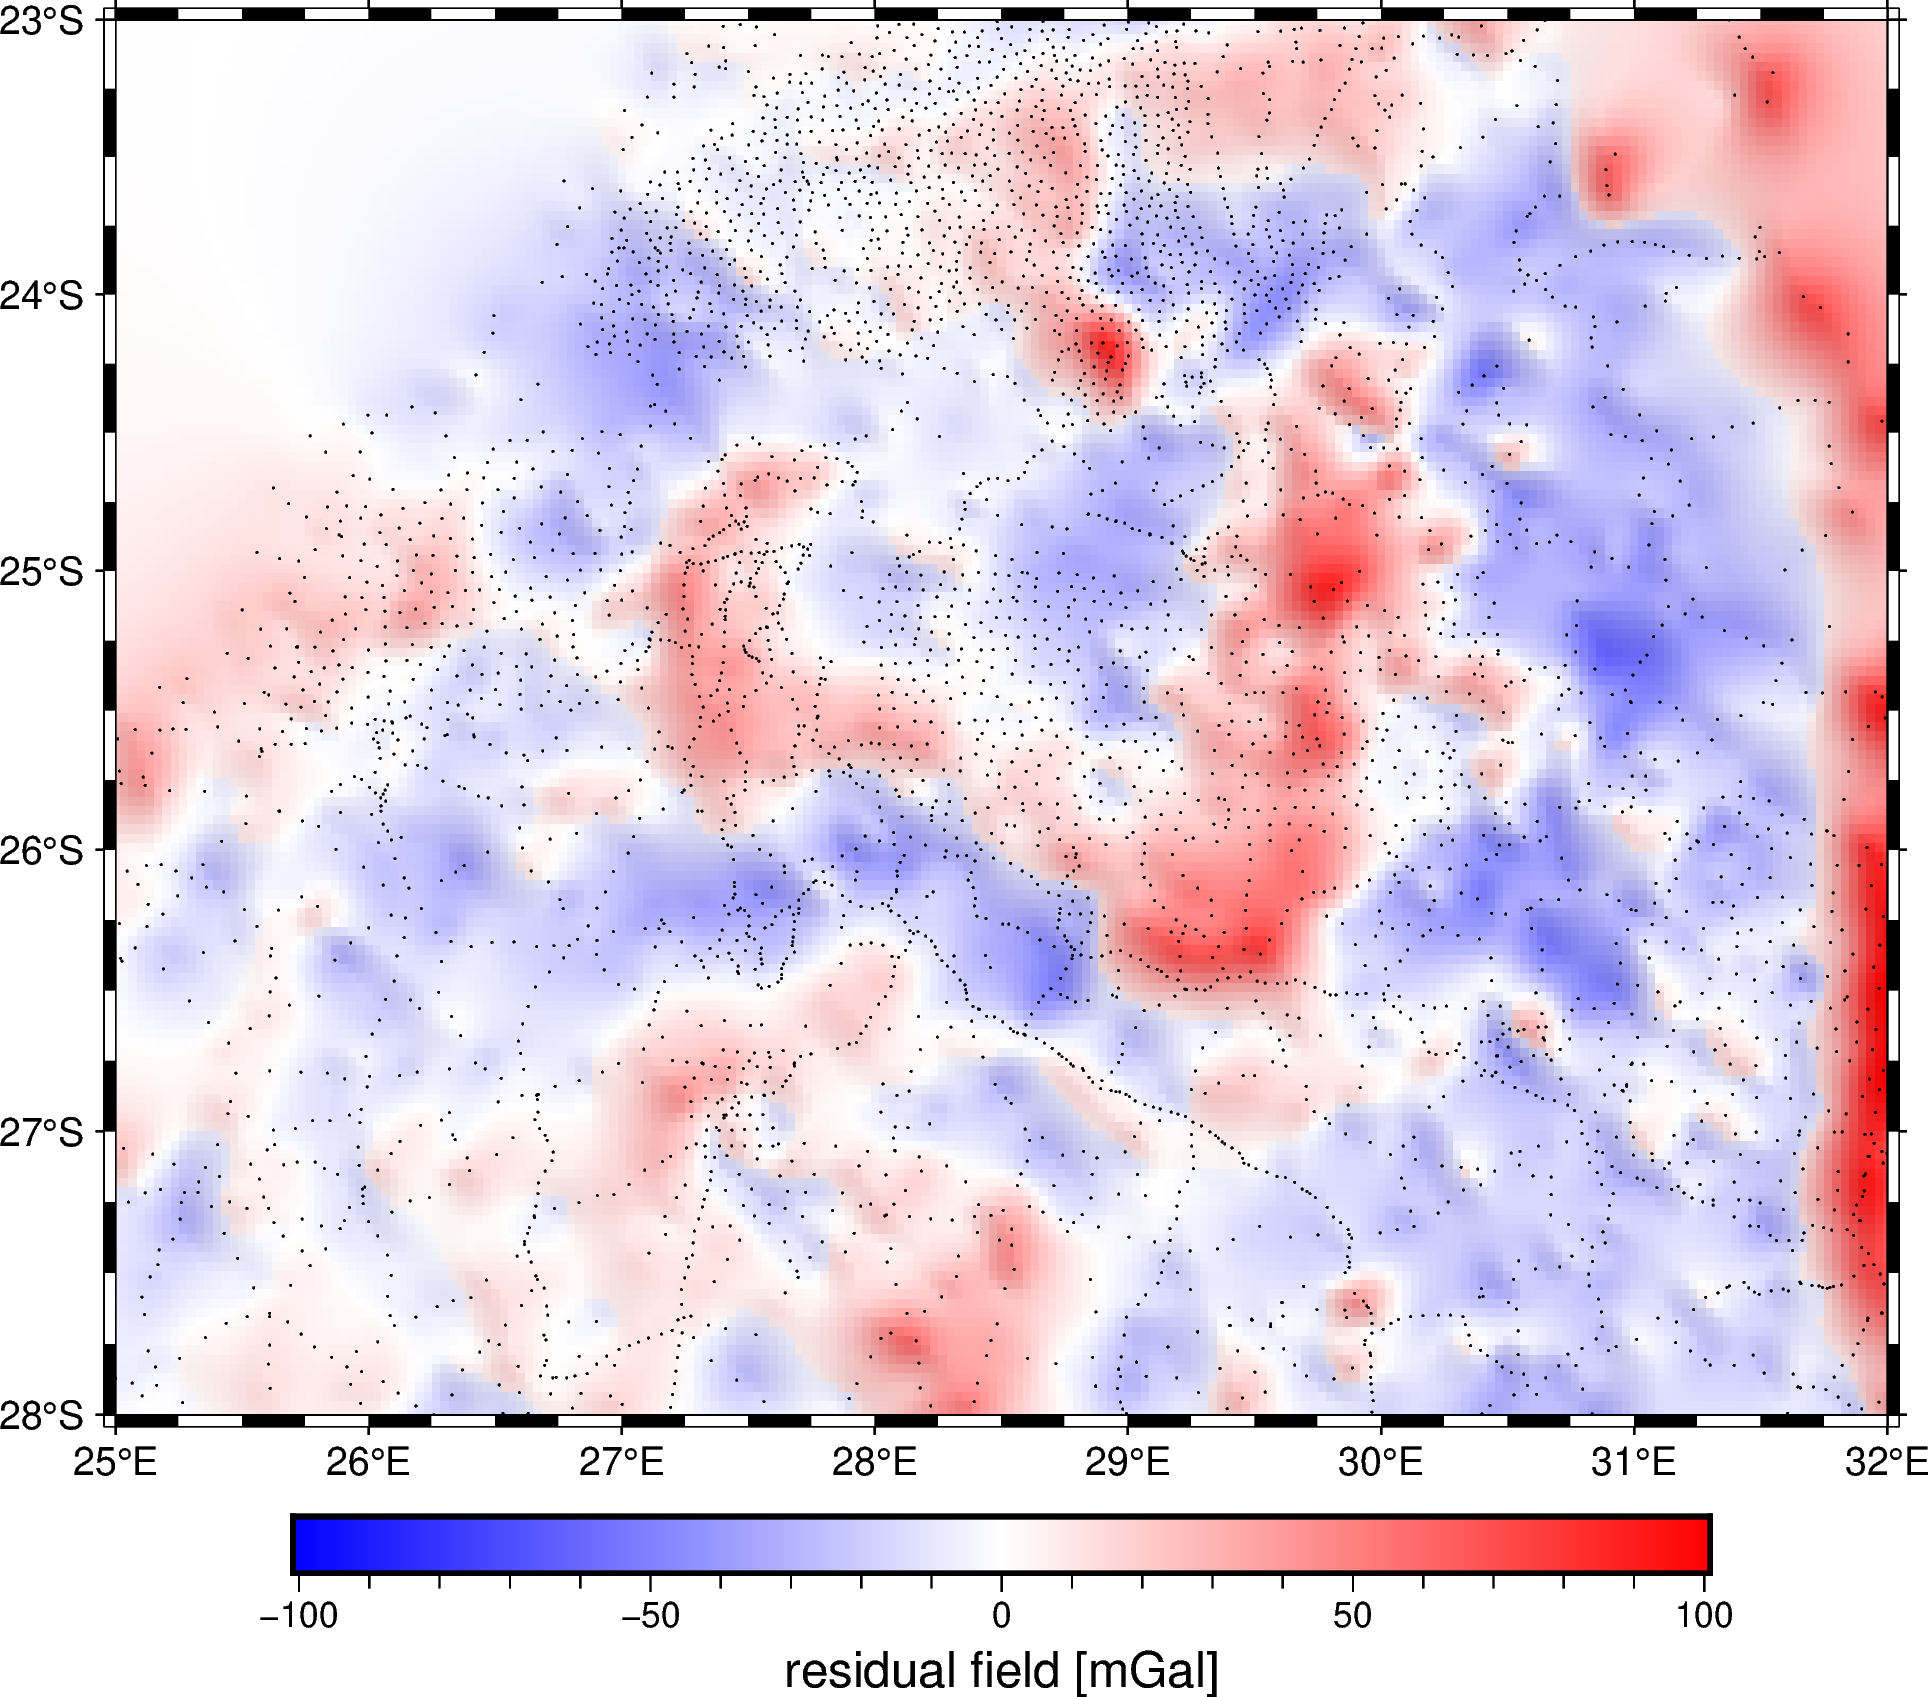

In [34]:
fig = pygmt.Figure()
scale = vd.maxabs(residual_grid.gravity_residual)
pygmt.makecpt(cmap="polar", series=[-scale, scale], no_bg=True)
fig.grdimage(
    residual_grid.gravity_residual,
    shading="+a45+nt0.15",
    projection="M15c",
    frame=True,
)
fig.colorbar(frame='af+l"residual field [mGal]"')
fig.plot(
    x=data.longitude,
    y=data.latitude,
    style="c0.02c",
    color="black",
)
fig.show()